## Inverse Cooking: Recipe Generation from Food Images

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from ipywidgets import FloatProgress
from PIL import Image
import time
import warnings
warnings.filterwarnings("ignore")

Set ```data_dir``` to the path including vocabularies and model checkpoint

In [2]:
data_dir = './data'

In [3]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = True # False
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [4]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
#ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
#ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
#vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
#pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
#pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))

ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [5]:
print (instrs_vocab_size, ingr_vocab_size)

23231 1488


In [6]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = os.path.join(data_dir, 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)


loaded model
Elapsed time: 3.689124584197998


In [7]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [8]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

Set ```use_urls = True``` to get recipes for images in ```demo_urls```. 

You can also set ```use_urls = False``` and get recipes for images in the path in ```data_dir/test_imgs```.

In [9]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = True # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = True #if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs')

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
            'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs

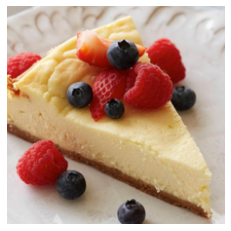

RECIPE 1

Title: Cheesecake

Ingredients:
sugar, egg, cheese, butter, cream, vanilla, extract, flour

Instructions:
-Preheat oven to 325f.
-Mix crumbs, butter and 2 tbsp.
-Sugar; press onto bottom of 9-inch springform pan.
-Bake 10 min.
-Beat cream cheese, remaining sugar and vanilla in large bowl with mixer until blended.
-Add sour cream; mix well.
-Add eggs, 1 at a time, mixing on low speed after each just until blended.
-Pour over crust.
-Bake 1 hour 10 min.
-Or until center is almost set.
-Run knife around rim of pan to loosen cake; cool before removing rim.
-Refrigerate cheesecake 4 hours.
RECIPE 2

Title: Cream cheese pound cake

Ingredients:
sugar, egg, cheese, butter, cream, vanilla, extract, flour

Instructions:
-Preheat the oven to 325.
-Grease and flour 2 standard (9-inch) round cake pans, or one 8-inch round cake pan, then line them with paper baking cups.
-Sift the flour and confectioners sugar into a large bowl.
-Use an electric mixer on medium to high speed, beat the cre

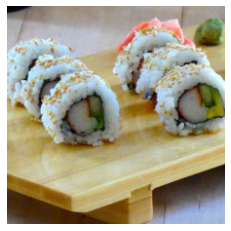

RECIPE 1

Title: California rolls

Ingredients:
rice, nori, seeds, avocado, cheese

Instructions:
-Mix the rice with the sushi rice.
-Spread the rice on a sheet of plastic wrap.
-Spread the avocado on top of the rice, and sprinkle with sesame seeds.
-Roll up the rice from step 1, and cut into 5 cm slices.
RECIPE 2

Title: California rolls for hinamatsuri

Ingredients:
rice, nori, seeds, avocado, cheese

Instructions:
-Slice the avocado into 2 cm wide pieces; cut the nori seaweed into 4 even pieces.
-Wrap 1 piece of cheese with nori seaweed, then the avocado.
-Top with the remaining sushi rice and sesame seeds, and finish with the rest of the toppings.
-You could also just mix the sushi rice into the sushi rice.
RECIPE 3

Title: California roll

Ingredients:
rice, nori, seeds, avocado, cheese

Instructions:
-Make the sushi rice.
-Mix together the ingredients for the sushi.
-Place the nori, avocado, cheese and rice on a nori sheet and roll it up tightly.
-Cut into bite-sized pieces.
-Pla

In [10]:
inverse_cooking_info = []

for img_file in demo_files:
    
    tmp_list = [[], [], [], []] # recipe_list, title_list, ingredients_list, instructions_list
    
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
        if valid['is_valid'] or show_anyways:
            
            print ('RECIPE', num_valid)
            tmp_list[0].append(num_valid)
            num_valid+=1
            #print ("greedy:", greedy[i], "beam:", beam[i])
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print (BOLD + '\nTitle:' + END,outs['title'])
            tmp_list[1].append(outs['title'])

            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))
            tmp_list[2].append(outs['ingrs'])

            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))
            tmp_list[3].append(outs['recipe'])

            print ('='*20)

        else:
            pass
            print ("Not a valid recipe!")
            print ("Reason: ", valid['reason'])
            
    inverse_cooking_info.append(tmp_list)    

In [11]:
print(inverse_cooking_info)

[[[1, 2, 3, 4], ['Cheesecake', 'Cream cheese pound cake', 'Vanilla and philly cheesecake', 'Cream cheese cheesecake'], [['sugar', 'egg', 'cheese', 'butter', 'cream', 'vanilla', 'extract', 'flour'], ['sugar', 'egg', 'cheese', 'butter', 'cream', 'vanilla', 'extract', 'flour'], ['sugar', 'egg', 'cheese', 'butter', 'cream', 'vanilla', 'extract', 'flour'], ['sugar', 'egg', 'cheese', 'butter', 'cream', 'vanilla', 'extract', 'flour']], [['Preheat oven to 325f.', 'Mix crumbs, butter and 2 tbsp.', 'Sugar; press onto bottom of 9-inch springform pan.', 'Bake 10 min.', 'Beat cream cheese, remaining sugar and vanilla in large bowl with mixer until blended.', 'Add sour cream; mix well.', 'Add eggs, 1 at a time, mixing on low speed after each just until blended.', 'Pour over crust.', 'Bake 1 hour 10 min.', 'Or until center is almost set.', 'Run knife around rim of pan to loosen cake; cool before removing rim.', 'Refrigerate cheesecake 4 hours.'], ['Preheat the oven to 325.', 'Grease and flour 2 stand